

```

Signature Verification using Siamese Network 

Details : 
1) We used Siamese Network connected with dense layer at the end which will decide either 0 or 1.

2) We Trained our Model on Online Available Signature Dataset which consists 54,408 Pairs of Real Signature and Forged Signature.


```



In [1]:
import pandas as pd
import numpy as np
import PIL.Image as Image
from PIL import ImageOps 
import dill
import tensorflow as tf
from tensorflow.keras.layers import *
from google.colab import output
import matplotlib.pyplot as plt

In [2]:
tf.keras.backend.set_floatx('float64')

<br><hr>
<br>
 **Data Loading** <br>

In [3]:
dataset=pd.read_csv('/content/drive/My Drive/Datasets/Signature_Verify/Dataset_Signature_Final/Dataset/data.csv')

In [4]:
x_dataset=dataset.iloc[:,[1,0,2]]

In [5]:
dataset=pd.concat([dataset,x_dataset])

In [6]:
indices=list(range(len(dataset)))
np.random.shuffle(indices)
dataset=dataset.iloc[indices]

In [7]:
val_dataset=pd.read_csv('/content/drive/My Drive/Datasets/Signature_Verify/sign_data/test_data.csv')
val_dataset.iloc[:,2]=1-val_dataset.iloc[:,2]
val_dataset.iloc[:,0:2]='/content/drive/My Drive/Datasets/Signature_Verify/sign_data/test/'+val_dataset.iloc[:,0:2]

In [8]:
indices=list(range(len(val_dataset)))
np.random.shuffle(indices)
val_dataset=val_dataset.iloc[indices]

<br><hr>
<br>
 **Defining Data Generators** <br>

In [9]:
def keras_train_gen(batch_size=32):
  #Image size : 200x200x3
  X=np.zeros((batch_size,2,200,200,1))
  Y=np.zeros((batch_size,1))

  i=0
  while(True):
    if i>=len(dataset)-(batch_size) :
      i=(i%(len(dataset)))-(batch_size+1) 

    for j in range(i,i+batch_size):
      img1=np.expand_dims(np.array(ImageOps.grayscale(Image.open(dataset.iloc[j,0]).resize((200,200)))),axis=-1)
      img2=np.expand_dims(np.array(ImageOps.grayscale(Image.open(dataset.iloc[j,1]).resize((200,200)))),axis=-1)
      
      for p in range(200):
        for q in range(200):
          if img1[p,q]>240 :
            img1[p,q]=0
          else :
            img1[p,q]=255

      for p in range(200):
        for q in range(200):
          if img2[p,q]>240 :
            img2[p,q]=0
          else :
            img2[p,q]=255

      X[j-i,0]=img1
      X[j-i,1]=img2
      Y[j-i]=dataset.iloc[j,2]
    i=i+batch_size
    X=X/255.0

    yield [X[:,0,:,:,:],X[:,1,:,:,:]],Y

In [10]:
def keras_val_gen(batch_size):
  #Image size : 200x200x1
  X=np.zeros((batch_size,2,200,200,1))
  Y=np.zeros((batch_size,1))

  i=0
  while(True):
    if i>=len(val_dataset)-(batch_size) :
      i=(i%(len(val_dataset)))-(batch_size+1) 
    for j in range(i,i+batch_size):
      img1=np.expand_dims(np.array(ImageOps.grayscale(Image.open(val_dataset.iloc[j,0]).resize((200,200)))),axis=-1)
      img2=np.expand_dims(np.array(ImageOps.grayscale(Image.open(val_dataset.iloc[j,1]).resize((200,200)))),axis=-1)
      
      for p in range(200):
        for q in range(200):
          if img1[p,q]>240 :
            img1[p,q]=0
          else :
            img1[p,q]=255

      for p in range(200):
        for q in range(200):
          if img2[p,q]>240 :
            img2[p,q]=0
          else :
            img2[p,q]=255
      
      X[j-i,0]=img1
      X[j-i,1]=img2
      Y[j-i]=val_dataset.iloc[j,2]
    i+=batch_size
    X=X/255.0

    yield [X[:,0,:,:,:],X[:,1,:,:,:]],Y

In [11]:
def distance(data):
  return tf.sqrt(tf.reduce_sum(tf.math.square(data[0]-data[1]),axis=-1))

<br><hr>
<br>
 **Loss Function** : It reduces distance b/w same and increases b/w forged. <br>

In [12]:
def contrastive_loss(y_true,y_pred):
  temp=tf.math.square(tf.math.maximum(tf.cast(0.0,tf.float64),tf.cast( (1.0-tf.cast(y_true,tf.float64))*(5.0-tf.math.square(y_pred)), tf.float64 ) ) ) + tf.cast(tf.math.square(tf.math.maximum(tf.cast(2.0,tf.float64),(tf.cast(y_true,tf.float64))*(tf.math.square(y_pred)) ) ),tf.float64)
  return temp 

<br><hr>
<br>
 **Model Architecture** <br>

In [13]:
#Define All Layers....

conv2d_1=Conv2D(32,(3,3),kernel_regularizer="l2")
norm_1=BatchNormalization()
act_1=Activation('relu')
dropout1=Dropout(0.4)
pool_1=MaxPool2D((2,2),strides=(2,2))

conv2d_2=Conv2D(64,(3,3),kernel_regularizer="l2")
norm_2=BatchNormalization()
act_2=Activation('relu')
dropout2=Dropout(0.4)
pool_2=MaxPool2D((2,2),strides=(2,2))


conv2d_3=Conv2D(128,(3,3),kernel_regularizer="l2")
norm_3=BatchNormalization()
act_3=Activation('relu')
dropout3=Dropout(0.4)
pool_3=MaxPool2D((2,2),strides=(2,2))

conv2d_4=Conv2D(264,(3,3),kernel_regularizer="l2")
norm_4=BatchNormalization()
act_4=Activation('relu')
dropout4=Dropout(0.4)
pool_4=MaxPool2D((2,2),strides=(2,2))

flatten=Flatten()

dense_1=Dense(500,kernel_regularizer="l2")
norm_5=BatchNormalization()
act_5=Activation('relu')
dropout5=Dropout(0.4)

dense_2=Dense(400,kernel_regularizer="l2")
norm_6=BatchNormalization()
act_6=Activation('sigmoid')

dense_3=Dense(300,kernel_regularizer="l2")
norm_7=BatchNormalization()
act7=Activation('sigmoid')

custom_layer=Lambda(distance)



<br>
<hr>



<br> **Making Keras Model** <br>

In [14]:
def keras_model():
  input_1=Input((200,200,1))
  input_2=Input((200,200,1))

  t=conv2d_1(input_1)
  t=norm_1(t)
  t=act_1(t)
  t=dropout1(t)
  t=pool_1(t)
  
  t=conv2d_2(t)
  t=norm_2(t)
  t=act_2(t)
  t=dropout2(t)
  t=pool_2(t)

  t=conv2d_3(t)
  t=norm_3(t)
  t=act_3(t)
  t=dropout3(t)
  t=pool_3(t)

  t=conv2d_4(t)
  t=norm_4(t)
  t=act_4(t)
  t=dropout4(t)
  t=pool_4(t)
  
  t=flatten(t)
  
  t=dense_1(t)
  t=norm_5(t)
  t=act_5(t)
  t=dropout5(t)
  
  
  t=dense_2(t)
  t=norm_6(t)
  t=act_6(t)

  t=dense_3(t)
  t=norm_7(t)
  a=act7(t)

  t1=conv2d_1(input_2)
  t1=norm_1(t1)
  t1=act_1(t1)
  t=dropout1(t)
  t1=pool_1(t1)
  
  t1=conv2d_2(t1)
  t1=norm_2(t1)
  t1=act_2(t1)
  t=dropout2(t)
  t1=pool_2(t1)

  t1=conv2d_3(t1)
  t1=norm_3(t1)
  t1=act_3(t1)
  t=dropout3(t)
  t1=pool_3(t1)

  t1=conv2d_4(t1)
  t1=norm_4(t1)
  t1=act_4(t1)
  t=dropout4(t)
  t1=pool_4(t1)
  
  t1=flatten(t1)
  
  t1=dense_1(t1)
  t1=norm_5(t1)
  t1=act_5(t1)
  t=dropout5(t)
  
  t1=dense_2(t1)
  t1=norm_6(t1)
  t1=act_6(t1)

  t1=dense_3(t1)
  t1=norm_7(t1)
  b=act7(t1)

  output=custom_layer([a,b])

  
  
  model=tf.keras.models.Model([input_1,input_2],output)

  return model





In [15]:
model=keras_model()

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [ ]:
model.summary()

In [18]:
model=tf.keras.models.load_model('/content/drive/My Drive/Datasets/Signature_Verify/',custom_objects={'contrastive_loss': contrastive_loss})

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=contrastive_loss)

In [20]:
class mycallback(tf.keras.callbacks.Callback):
  def on_train_batch_end(self, batch, logs={}):
    if batch%100==0 :
      self.model.save('/content/drive/My Drive/Datasets/Signature_Verify/')

In [21]:
train_generator=keras_train_gen(32)
val_generator=keras_val_gen(32)

In [ ]:
history=model.fit_generator(train_generator,steps_per_epoch=len(dataset)//32,epochs=20,validation_data=val_generator,validation_steps=len(val_dataset)//32,callbacks=[mycallback()])

In [ ]:
model.save('/content/drive/My Drive/Datasets/Signature_Verify/')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Datasets/Signature_Verify/assets


In [ ]:
eval_generator=keras_val_gen(32)
x,y=next(eval_generator)
y_pred=model.predict(x)
avg_0=[]
avg_1=[]
for i in range(len(y_pred)):
  if y[i,0]==0:
    avg_0.append(y_pred[i])
  else :
    avg_1.append(y_pred[i])
  print("Y_True : "+str(y[i])+"     Y_Pred : "+str(y_pred[i]))

In [24]:
np.average(avg_0)

1.3244938776940813

In [25]:
np.average(avg_1)

0.5668907520303599

In [26]:
def find_accuracy(data_gen,steps,split):
  acc=[]
  precision=[]
  recall=[]
  e=1e-11
  for i in range(steps):
    x,y=next(data_gen)
    y_pred=model.predict(x)

    count=0
    tp=e
    fp=e
    fn=e
    for j in range(len(y_pred)):
      if y[j,0]==0 and y_pred[j]>=split or y[j,0]==1 and y_pred[j]<split :
        count+=1
      if y[j,0]==1 and y_pred[j]<split : 
        tp+=1
      if y[j,0]==0 and y_pred[j]<split :
        fp+=1
      if y[j,0]==1 and y_pred[j]>=split :
        fn+=1

    acc.append(count/len(y_pred))
    precision.append(tp/(tp+fp))
    recall.append(tp/(tp+fn))
    output.clear(wait=True)
    print("Acc. : "+str(np.average(acc)))
    print("Precision : "+str(np.average(precision)))
    print("Recall : "+str(np.average(recall)))
    plt.plot(range(len(acc)),acc,color="blue")
    plt.scatter(len(acc)-1,acc[len(acc)-1],color="red")
    plt.xlabel("Batches")
    plt.ylabel("Accuracy")
    plt.show()

Acc. : 0.5822276536312849
Precision : 0.5538583222791014
Recall : 0.6885702955794156


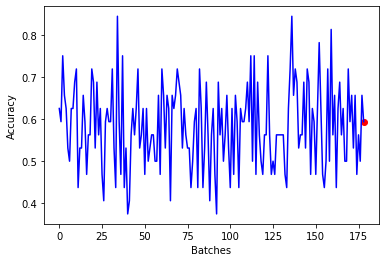

In [27]:
find_accuracy(keras_val_gen(32),len(val_dataset)//32,0.90)